In [1]:
# For a given coordinate (x,y), find the cluster it belongs to.
# return [cluster_number, x_coordinate, y_coordinate].

def find_cluster(x, y):
    centers = pd.read_csv('centers.csv')
    distance2 = (centers['0'] - x)**2 + (centers['1'] - y)**2
    nearest_cluster = np.argmin(np.array(distance2))
    return list(centers.iloc[nearest_cluster])

In [2]:
import numpy as np
import pandas as pd
from joblib import dump, load
from datetime import datetime, timedelta
from datetime import date
import pytz
from dateutil import parser
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
# from scipy.spatial import distance
# import mplcursors

import warnings
warnings.filterwarnings('ignore')

In [3]:
# For a given coordinate (x,y), find the nearest N parking lots in the same cluster
# return a Pandas DataFrame (named "nearest_N") of the N parking lots, 
# with features including ['segmentid', 'streetname', 'x', 'y', 'cluster'].

def find_nearest_N(x, y, N):
    center_info = find_cluster(x, y)
    segment_info = pd.read_csv('segment_info.csv')
    same_area = segment_info[segment_info['cluster']==int(center_info[0])]
    same_area['distance'] = (same_area['x'] - x)**2 + (same_area['y'] - y)**2
    nearest_N = same_area.nsmallest(N, 'distance')[['segmentid', 'streetname', 'x', 'y', 'cluster']]
    return nearest_N

In [4]:
# Turn the string input of address by Google Maps API to the format suitable for processing.
# return (weekday, hour).

def compute_time(time):
    day = 0
    hour = 0
    minute = 0
    time_str = time.split()
    for i, each in enumerate(time_str):
        if each == 'day' or each == 'days':
            day = int(time_str[i-1])
        if each == 'hour' or each == 'hours':
            hour = int(time_str[i-1])
        if each == 'min' or each == 'mins':
            minute = int(time_str[i-1])
    arrive_time = datetime.utcnow() + timedelta(days=day, hours=hour, minutes=minute) + timedelta(hours=-7)
    return ((date.weekday(arrive_time) + 1) % 7, arrive_time.hour)

In [5]:
# For the N nearest parking lots, predict the availability of parking spots in each of them.
# Add a new feature (named "availability") to the Pandas DataFrame nearest_N,
# and return the DataFrame.

def predict_N(nearest_N, time):
    pred = [] # This is the buffer to hold predicted availability of each of the N nearest parking lots.
    all_lots = pd.read_csv('testdata.csv')
    all_segments = pd.read_csv('segment_info.csv')
    centers = pd.read_csv('centers.csv')
    
    (weekday, hour) = compute_time(time) # Compute the arrival time of user
    
    # For each of the N parking lots:
    for k in range(len(nearest_N)):
        # First find out the history record of the same parking lot from testdata.
        segmentid = nearest_N.iloc[k]['segmentid']
        idx = all_lots.index[(all_lots['segmentid']==segmentid) & (all_lots['weekday']==weekday) & (all_lots['time']==hour)]
        full_capacity = list(all_segments[all_segments['segmentid']==segmentid]['capacity'])[0]
        x = list(all_segments[all_segments['segmentid']==segmentid]['x'])[0] # The x coordinate of parking lot
        y = list(all_segments[all_segments['segmentid']==segmentid]['y'])[0] # # The y coordinate of parking lot
        cluster_num = list(all_segments[all_segments['segmentid']==segmentid]['cluster'])[0] # The number of the cluster it belongs to
        center_x = list(centers[centers['centerid']==cluster_num]['0'])[0] # The x coordinate of cluster center
        center_y = list(centers[centers['centerid']==cluster_num]['1'])[0] # The y coordinate of cluster center
        distance = np.sqrt((x-center_x)**2 + (y-center_y)**2) # Compute the distance to the cluster center
        
        # Extract from testdata and make prediction
        prediction_number = []
        for i, each in enumerate(idx):
            # Just to prevent there is no sufficient history record for a given weekday or hour.
            if i == 0:
                continue
            # Extract history record of 24 hours from testdata each time.
            extract_testdata = all_lots.iloc[each-23:each+1]
            features = ['segmentid','ratio','capacity','occupied','distance','week','hour']
            for j in range(24):
                features += [str(j+1)]
            X = pd.DataFrame(columns=features)
            X['segmentid'] = extract_testdata['segmentid']
            X['week'] = extract_testdata['weekday']
            X['hour'] = extract_testdata['time']
            X['capacity'] = full_capacity
            X['occupied'] = extract_testdata['occupied']
            X['ratio'] = X['occupied'] / X['capacity']
            X['distance'] = distance * 1000
            for j in range(24):
                index = -j - 1
                rotate_data = list(X['occupied'])[index:] + list(X['occupied'])[:index]
                X[str(j+1)] = rotate_data
            test_features = ['capacity','distance','week','hour']
            
            # Make predictions
            for i in range(24):
                test_features += [str(i+1)]
            test_X = np.array(X[test_features].iloc[0]).reshape(1, -1)
            model_name = 'area' + str(cluster_num) + '.joblib'
            reg = load(model_name)
            prediction_number.append(reg.predict(test_X))
            pred_result = np.mean(np.array(prediction_number))
            if pred_result > full_capacity:
                pred_result = full_capacity
        pred.append(full_capacity - pred_result)
        
    # Add the predicted availability to DataFrame
    nearest_N['availability'] = np.array(pred)
    return nearest_N

# Recommendation Part 

In [6]:
def w(x1,y1,x2,y2):
#     walking distance caculation 
#     manhhatan
# 87.8km/degree
# 111.15km/degree
    a = np.array([x1,y1])
    if len(a.shape) == 1:
        a = a[:,np.newaxis]
    b = np.array([x2,y2]) 
    if len(b.shape) == 1:
        b = b[:,np.newaxis]
    diff = np.multiply(a-b,np.array([[87.8],[111.15]]) )
    dist = np.abs(diff[0,:]) +  np.abs(diff[1,:])
    return dist * 15  #avg walking speed 15min/km



def d(x1,y1,x2,y2):
#     walking distance caculation 
#     manhhatan
# 87.8km/degree
# 111.15km/degree
    a = np.array([x1,y1])
    if len(a.shape) == 1:
        a = a[:,np.newaxis]
    b = np.array([x2,y2]) 
    if len(b.shape) == 1:
        b = b[:,np.newaxis]
    diff = np.multiply(a-b,np.array([[87.8],[111.15]]) )
    dist = np.abs(diff[0,:]) +  np.abs(diff[1,:])
    return dist * 4.4 #avg driving speed 15min/km

def eval_aval(aval,a=0.3):
    return 1- np.exp(-a*aval)
# def score(v)
#    return  v*  

In [7]:
def park_score(x1, y1, x2, y2, nearest_N, plot = False, test = False):
# x1,y1: origin's coordinate
# x2,y2: target's coordinate 
# test: when test set visited parking lot aval t0 0 manually
    # Initialization
    penalty_1 = 50 # penalty for not finding a parking space in the end
    penalty_2 = 10 # penalty for moving around in a parking lot and finding it's full 
    idx = nearest_N.axes[0]
    segmentid = nearest_N["segmentid"]
    x = nearest_N["x"]
    y = nearest_N["y"]
    aval = nearest_N["availability"]
    ##########################
    # Test Mode
    if test:
        for i in test:
            if i in nearest_N.index:
                aval[i] = 0
    ##########################
#     eval avalability as a (0,1) prob
    p = eval_aval(aval,0.3)
#     initialize the evaluation value for each park
    v = p * w(x,y,x2,y2) + (1 - p) * penalty_1
    v_init = v.copy()
    for i in range(100):
        for n in idx:
            v_old = v.copy()
            temp = v.copy() 
            for m in idx:
                if n!= m and v[m] > v[n]:
                    temp[m] += d(x[m],y[m], x[n],y[n])
                else:
                    temp[m]+= 99999         
            v_m = min(temp)
            if v_m > 99999:
                v_m = max(v)
            v[n] = p[n]* w(x[n],y[n],x2,y2) +  (1 - p[n])  * (v_m + penalty_2)
        if (np.linalg.norm(v-v_old) < 1e-6 ):
            break
    v += d(x,y, x1,y1)
    
    if plot:
        x_pos = x*87.8
        y_pos = y*111.15
        
        plt.figure(figsize=(15,10))
        # initialized recommendation level
        plt.scatter(x_pos , y_pos, c = aval, s = 200000/v_init/v_init/v_init ,cmap = 'Reds'  )
        plt.scatter(x1*87.8, y1*111.15, s=100 , marker = "*", label ="origin",c = 'b')
        plt.scatter(x2*87.8, y2*111.15, s=100, marker = "X", label ="destination",c ='g')
        plt.legend()
        for i in idx:
            plt.annotate(i, (x_pos [i], y_pos[i]))
    
        plt.figure(figsize=(15,10))
        # coveged recommendation level
        plt.scatter(x_pos , y_pos, c = aval, s = np.exp(200000/v/v/v)/30 ,cmap = 'Reds')
        plt.scatter(x1*87.8, y1*111.15, s=100, marker = "*", label ="origin", c = 'b')
        plt.scatter(x2*87.8, y2*111.15, s=100, marker = "X", label ="destination", c ='g')
        plt.legend()
        for i in idx:
            plt.annotate(i, (x_pos [i], y_pos[i]))
        
    return v

In [8]:
def park_recommd(x1, y1, x2, y2, time, N, M, plot = False , test = False):
# x1,y1: origin's coordinate
# x2,y2: target's coordinate
# time: expeected arriving time 
# Select best M from N nearest parking lots 
    # find N nearest parking lots
    find_cluster(x2,y2)
    print(find_cluster(x2,y2))
    nearest_N = find_nearest_N(x2, y2, N)
    (weekday, hour) = compute_time(time)
    nearest_N = predict_N(nearest_N, time)
    # get the each ones infomation (including expected time to find parking space with each choice)
    park_val = park_score(x1, y1, x2, y2, nearest_N, plot ,test)
    v_info = pd.DataFrame({'exp_time':park_val,'x':nearest_N['x'],'y':nearest_N['y'], 'availability': nearest_N['availability'] })
    
    return v_info.nsmallest(M,'exp_time',keep='first')

[5.0, -122.3952897, 37.77697665]


,exp_time,x,y,availability
142,27.665101,-122.397487,37.777691,9.891079
141,27.960092,-122.395475,37.779277,8.865357
124,28.809347,-122.397360,37.778873,10.779375
203,28.894253,-122.393935,37.778037,7.889664
121,30.386595,-122.393601,37.779408,10.570888


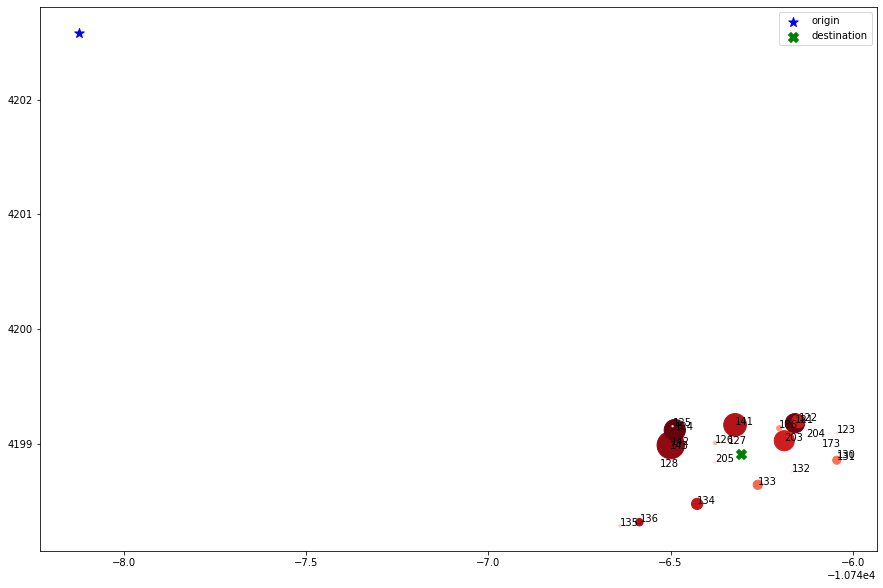

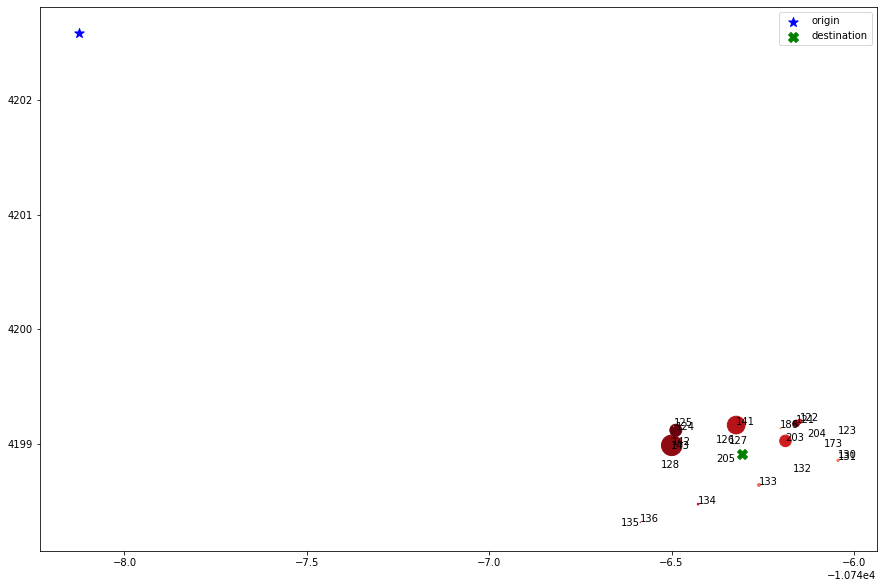

In [9]:
# a few testcases
# ####################
# Cluster 2
x_org = -122.416
y_org = 37.81
# x_dest = -122.419
# y_dest = 37.808
###########################
# Cluster 5
# x_org = -122.3952897
# y_org = 37.77697665
x_dest = -122.3952897
y_dest = 37.77697665

############################
# x_org = -122.630
# y_org = 37.908
# x_dest = -122.620
# y_dest = 37.908
###########################
# x_dest = -122.425
# y_dest = 37.800
###########################
# x_dest = -122.43
# y_dest = 37.808
############################
# x_dest = -122.4108
# y_dest = 37.80785

time = '1 hours 30 mins'

park_info = park_recommd(x_org,y_org, x_dest,y_dest, time,50,5, plot = True)
park_info

# Evaluation

In [10]:
#  Test case

x_org = -122.416
y_org = 37.81
x_dest = -122.419
y_dest = 37.808
time = '1 hours 30 mins'
####################################
# x_org = -122.428
# y_org = 37.81
# x_dest = -122.420
# y_dest = 37.808
# time = '1 hours 30 mins'
#####################################
# x_org = -122.428
# y_org = 37.81
# x_dest = -122.422
# y_dest = 37.818
# time = '1 hours 30 mins'

In [15]:
# Initialization
x = x_org
y = y_org
time1 = 0
p = 1
visited = []
idx = 0


# find the first nearest parking space     
find_cluster(x_dest,y_dest)
nearest_N = find_nearest_N(x_dest,y_dest, 1)
(weekday, hour) = compute_time(time)
nearest_N = predict_N(nearest_N, time)
for i in range(len(nearest_N.index)):
    if nearest_N.index[i] not in visited:
        idx = nearest_N.index[i]
        break
visited.append(idx)
x_tmp = nearest_N['x'][idx]
y_tmp = nearest_N['y'][idx]
p_temp = eval_aval(nearest_N['availability'][idx])

time1 += d(x,y,x_tmp,y_tmp) + p* p_temp * w(x_tmp,y_tmp,x_dest,y_dest) + p* (1-p_temp)*10 
p = p*(1 - p_temp) 
x = x_tmp
y = y_tmp
print("Parking lot choice: ",idx ,"  Prob not found:",p,"Expected total time: ",time1)

return_file = []

# loop until not found prob < 0.01
while p > 0.01:
    find_cluster(x,y)
    nearest_N = find_nearest_N(x,y, len(visited)+2)
    (weekday, hour) = compute_time(time)
    nearest_N = predict_N(nearest_N, time)  
    for i in range(len(nearest_N.index)):
        if nearest_N.index[i] not in visited:
            
            idx = nearest_N.index[i]
            break
    visited.append(idx)
    x_tmp = nearest_N['x'][idx]
    y_tmp = nearest_N['y'][idx]
    p_temp = eval_aval(nearest_N['availability'][idx])
    time1 += d(x,y,x_tmp,y_tmp) + p* p_temp * w(x_tmp,y_tmp,x_dest,y_dest) + p* (1-p_temp)*10 
    p = p*(1 - p_temp) 
    x = x_tmp
    y = y_tmp
    return_segmentid = nearest_N['segmentid'][idx]
    return_x = nearest_N['x'][idx]
    return_y = nearest_N['y'][idx]
    return_street_name = nearest_N['streetname'][idx]
    return_file.append([return_segmentid, return_x, return_y, return_street_name])
    print("Parking lot choice:", return_segmentid, "   x:", return_x, "   y:", return_y, "   Street Name:", return_street_name)
#     print("Parking lot choice: ",idx ,"  Prob not found:",p,"Expected total time: ",time1)
pd.DataFrame(return_file).to_csv('output.csv', header=False, index=False)

Parking lot choice:  28   Prob not found: 0.8176827003901772 Expected total time:  [10.8868328]
Parking lot choice: 326062    x: -122.419497586    y: 37.80684067595    Street Name: Beach St (600-698)
Parking lot choice: 546273    x: -122.41892878700001    y: 37.80663196535    Street Name: Leavenworth St (2701-2715)
Parking lot choice: 326052    x: -122.4181100382    y: 37.8070171998    Street Name: Beach St (500-598)
Parking lot choice: 502282    x: -122.41726312615    y: 37.80742707705001    Street Name: Jones St (2800-2898)
Parking lot choice: 326042    x: -122.416483102    y: 37.8072254074    Street Name: Beach St (400-498)


In [12]:
# Initialization
x = x_org
y = y_org
time1 = 0
p = 1
visited = []
idx = 0

# loop until not found prob < 0.01
while p > 0.01:
    park_info = park_recommd(x, y, x_dest,y_dest, time, 10, 3, test = visited)
    park_info
    idx = park_info.index[0]
    x_tmp = park_info['x'][idx]
    y_tmp = park_info['y'][idx]
    p_temp = eval_aval(park_info['availability'][idx])
    visited.append(idx)
    time1 += d(x,y,x_tmp,y_tmp) + p* p_temp * w(x_tmp,y_tmp,x_dest,y_dest) + p* (1 - p_temp) * 10 
    p = p * (1 - p_temp) 
    x = x_tmp
    y = y_tmp
    print("Parking lot choice: ",idx ,"  Prob not found:",p,"Expected total time: ",time1)


[2.0, -122.41717709999999, 37.80669257]
Parking lot choice:  26   Prob not found: 0.1958426709936425 Expected total time:  [6.31232706]
[2.0, -122.41717709999999, 37.80669257]
Parking lot choice:  15   Prob not found: 0.05675348497868961 Expected total time:  [8.38985492]
[2.0, -122.41717709999999, 37.80669257]
Parking lot choice:  21   Prob not found: 0.01929225992772842 Expected total time:  [9.92258536]
[2.0, -122.41717709999999, 37.80669257]
Parking lot choice:  14   Prob not found: 0.00920119222658169 Expected total time:  [10.73889357]
